In [1]:
%matplotlib inline
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interactive, FloatSlider, RadioButtons, SelectionSlider, HBox, VBox, Layout
import matplotlib.pyplot as plt
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS
from datetime import datetime, timedelta
from netCDF4 import num2date
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from metpy.units import units

In [2]:
# Request the GFS data from the thredds server
gfs = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p5deg/catalog.xml')
dataset = list(gfs.datasets.values())[1]
dataset.access_urls

# Create NCSS object to access the NetcdfSubset
from siphon.ncss import NCSS
ncss = NCSS(dataset.access_urls['NetcdfSubset'])

# get current date and time
now = datetime.utcnow()
now = datetime(now.year, now.month, now.day, now.hour)

# define time range you want the data for
start = now
end = now + timedelta(hours=12)

In [3]:
query = ncss.query()
query.time_range(start, end)
query.lonlat_box(north=60, south=20, east=310, west=230)
query.accept('netcdf4')
query.variables('Temperature_surface', 'Relative_humidity_entire_atmosphere_single_layer', 'Wind_speed_gust_surface')

var=Relative_humidity_entire_atmosphere_single_layer&var=Wind_speed_gust_surface&var=Temperature_surface&time_start=2016-08-23T22%3A00%3A00&time_end=2016-08-24T10%3A00%3A00&east=310&west=230&south=20&north=60&accept=netcdf4

In [4]:
# Helper function for finding proper time variable
def find_time_var(var, time_basename='time'):
    for coord_name in var.coordinates.split():
        if coord_name.startswith(time_basename):
            return coord_name
    raise ValueError('No time variable found for ' + var.name)

In [5]:
# Request data for the variables you want to use
data = ncss.get_data(query)
print(list(data.variables))

['Relative_humidity_entire_atmosphere_single_layer', 'reftime', 'time', 'lat', 'lon', 'Wind_speed_gust_surface', 'Temperature_surface']


In [6]:
# Pull out the lat and lon data
lat = data.variables['lat'][:]
lon = data.variables['lon'][:]

# Get time into a datetime object
time_var = data.variables[find_time_var(data.variables['Temperature_surface'])]
time_var = num2date(time_var[:], time_var.units).tolist()
time_strings = [t.strftime('%m/%d %H:%M') for t in time_var]

# Combine 1D latitude and longitudes into a 2D grid of locations
lon_2d, lat_2d = np.meshgrid(lon, lat)

In [7]:
def plot(varname='', time=0, colormap=''):
    variable = data.variables[varname][:]
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
    ax.set_extent([235., 290., 20., 55.])
    ax.set_title('GFS 12-Hour Forecast', size=16)
    
    # Add state boundaries to plot
    states_provinces = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines',
                                                scale='50m', facecolor='none')
    ax.add_feature(states_provinces, edgecolor='black', linewidth=1)

    # Add country borders to plot
    country_borders = cfeature.NaturalEarthFeature(category='cultural', name='admin_0_countries', 
                                               scale='50m',facecolor='none')
    ax.add_feature(country_borders, edgecolor='black', linewidth=1)
    
    if varname == 'Temperature_surface':
        variable = (variable * units.kelvin).to('degF')
        
    # Contour based on variable chosen
    c = ax.contourf(lon_2d, lat_2d, variable[time_strings.index(time)], cmap=colormap)
    cb = fig.colorbar(c, ax=ax, shrink=0.7)
    
    if varname == 'Temperature_surface':
        cb.set_label(r'$^{o}F$', size='large')
    if varname == 'Relative_humidity_entire_atmosphere_single_layer':
        cb.set_label(r'$\%$', size='large')
    if varname == 'Wind_speed_gust_surface':
        cb.set_label(r'$m/s$', size='large')

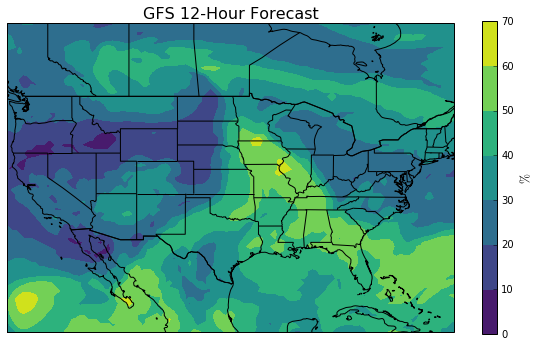

In [8]:
x = interactive(plot, varname=widgets.Dropdown(options={'Temperature': 'Temperature_surface', 
    'Relative Humidity': 'Relative_humidity_entire_atmosphere_single_layer', 'Wind Speed': 'Wind_speed_gust_surface'}, 
    description='Variable', alignment='center'), time=widgets.SelectionSlider(description='Time', options=time_strings, 
    width='40%'), colormap=widgets.RadioButtons(description='Colormap', options=['viridis', 'coolwarm', 'YlGnBu', 'RdPu']))
display(x)